In [ ]:
!pip install -q sentence-transformers scikit-learn matplotlib seaborn transformers nltk

In [ ]:
import ast
import os
import math
import json
from typing import List, Dict, Any
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
!python -m nltk.downloader punkt

<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
snippets = [
"""
import math

def factorial(n):
    if n==0:
        return 1
    return n*factorial(n-1)
""",
"""
from collections import Counter

def most_common(items):
    c = Counter(items)
    return c.most_common(1)[0]
""",
"""
class Stack:
    def __init__(self):
        self.s=[]
    def push(self,x):
        self.s.append(x)
    def pop(self):
        return self.s.pop()
""",
"""
def bubble_sort(arr):
    n=len(arr)
    for i in range(n):
        for j in range(0, n-i-1):
            if arr[j]>arr[j+1]:
                arr[j], arr[j+1] = arr[j+1], arr[j]
    return arr
""",
"""
import requests

def fetch_json(url):
    r = requests.get(url)
    return r.json()
""",
"""
def fibonacci(n):
    a,b=0,1
    for _ in range(n):
        a,b=b,a+b
    return a
""",
"""
def is_prime(n):
    if n<=1: return False
    if n<=3: return True
    if n%2==0 or n%3==0: return False
    i=5
    while i*i<=n:
        if n%i==0 or n%(i+2)==0:
            return False
        i+=6
    return True
""",
"""
def flatten(nested):
    out=[]
    for sub in nested:
        for elem in sub:
            out.append(elem)
    return out
""",
"""
from functools import lru_cache

@lru_cache(None)
def tribonacci(n):
    if n<3:
        return 1
    return tribonacci(n-1)+tribonacci(n-2)+tribonacci(n-3)
""",
"""
async def get_data(session, url):
    async with session.get(url) as resp:
        return await resp.json()
"""
]

len(snippets)


10

In [ ]:
def extract_ast_info(code_str: str):
    tree = ast.parse(code_str)
    functions = []
    classes = []
    imports = []
    patterns = {
        'recursion': False,
        'decorators': False,
        'async': False,
        'list_comprehension': False,
    }
    for node in ast.walk(tree):
        if isinstance(node, ast.FunctionDef):
            fn_name = node.name
            doc = ast.get_docstring(node)
            functions.append({'name': fn_name, 'doc': doc})
            for n in ast.walk(node):
                if isinstance(n, ast.Call) and isinstance(n.func, ast.Name) and n.func.id == fn_name:
                    patterns['recursion'] = True
                if isinstance(n, ast.AsyncFunctionDef):
                    patterns['async'] = True
                if isinstance(n, ast.ListComp):
                    patterns['list_comprehension'] = True
                if node.decorator_list:
                    patterns['decorators'] = True
        if isinstance(node, ast.ClassDef):
            classes.append(node.name)
        if isinstance(node, (ast.Import, ast.ImportFrom)):
            if isinstance(node, ast.Import):
                for n in node.names:
                    imports.append(n.name)
            else:
                imports.append(node.module)
        if isinstance(node, ast.AsyncFunctionDef):
            patterns['async'] = True
    return {
        'functions': functions,
        'classes': classes,
        'imports': list(set([i for i in imports if i])),
        'patterns': patterns
    }

summaries = [extract_ast_info(s) for s in snippets]

for i, s in enumerate(summaries):
    print(i, s)


0 {'functions': [{'name': 'factorial', 'doc': None}], 'classes': [], 'imports': ['math'], 'patterns': {'recursion': True, 'decorators': False, 'async': False, 'list_comprehension': False}}
1 {'functions': [{'name': 'most_common', 'doc': None}], 'classes': [], 'imports': ['collections'], 'patterns': {'recursion': False, 'decorators': False, 'async': False, 'list_comprehension': False}}
2 {'functions': [{'name': '__init__', 'doc': None}, {'name': 'push', 'doc': None}, {'name': 'pop', 'doc': None}], 'classes': ['Stack'], 'imports': [], 'patterns': {'recursion': False, 'decorators': False, 'async': False, 'list_comprehension': False}}
3 {'functions': [{'name': 'bubble_sort', 'doc': None}], 'classes': [], 'imports': [], 'patterns': {'recursion': False, 'decorators': False, 'async': False, 'list_comprehension': False}}
4 {'functions': [{'name': 'fetch_json', 'doc': None}], 'classes': [], 'imports': ['requests'], 'patterns': {'recursion': False, 'decorators': False, 'async': False, 'list_comp

In [ ]:
def make_summary_text(code_str, ast_info):
    parts = []
    if ast_info['imports']:
        parts.append('imports: ' + ', '.join(ast_info['imports']))
    if ast_info['classes']:
        parts.append('classes: ' + ', '.join(ast_info['classes']))
    if ast_info['functions']:
        parts.append('functions: ' + ', '.join([f['name'] for f in ast_info['functions']]))
    patt = [k for k,v in ast_info['patterns'].items() if v]
    if patt:
        parts.append('patterns: ' + ', '.join(patt))
    parts.append('code: ' + ' '.join(code_str.strip().split()))
    return ' | '.join(parts)

texts = [make_summary_text(snippets[i], summaries[i]) for i in range(len(snippets))]

for t in texts[:2]:
    print('----')
    print(t[:400])


----
imports: math | functions: factorial | patterns: recursion | code: import math def factorial(n): if n==0: return 1 return n*factorial(n-1)
----
imports: collections | functions: most_common | code: from collections import Counter def most_common(items): c = Counter(items) return c.most_common(1)[0]


In [ ]:
models = {
    'MiniLM': 'sentence-transformers/all-MiniLM-L6-v2',
    'DistilRoBERTa': 'stsb-distilroberta-base-v2',
    'MPNet': 'sentence-transformers/all-mpnet-base-v2'
}
encoders = {name: SentenceTransformer(path) for name, path in models.items()}

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/680 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
raw_embeddings = {}
summary_embeddings = {}

for name, enc in encoders.items():
    raw_embeddings[name] = enc.encode(snippets, convert_to_numpy=True, show_progress_bar=True)
    summary_embeddings[name] = enc.encode(texts, convert_to_numpy=True, show_progress_bar=True)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
def pairwise_cosine_matrix(mat):
    return cosine_similarity(mat)

sim_matrices = {m: pairwise_cosine_matrix(summary_embeddings[m]) for m in summary_embeddings}
mean_pairwise = {
    m: (np.triu(sim_matrices[m], 1).sum() * 2) / (len(snippets)*(len(snippets)-1))
    for m in sim_matrices
}
mean_pairwise

{'MiniLM': np.float32(0.31882253),
 'DistilRoBERTa': np.float32(0.40321833),
 'MPNet': np.float32(0.32098398)}

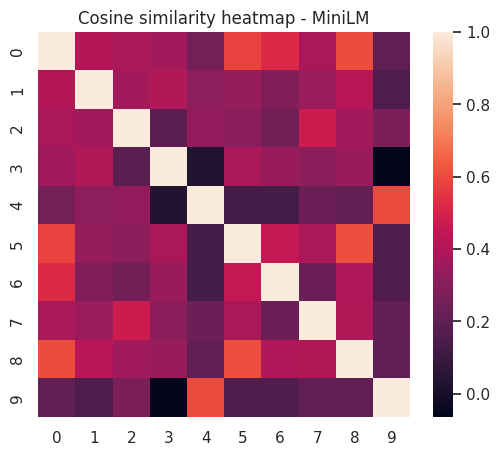

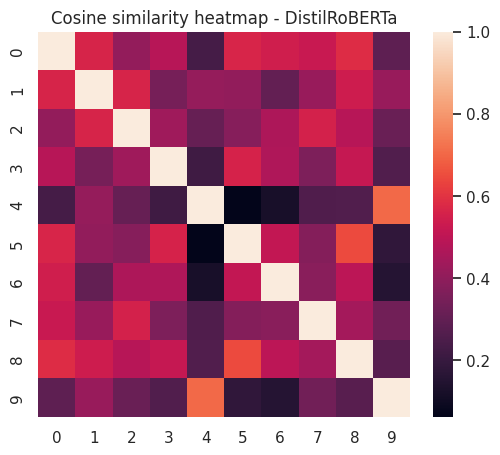

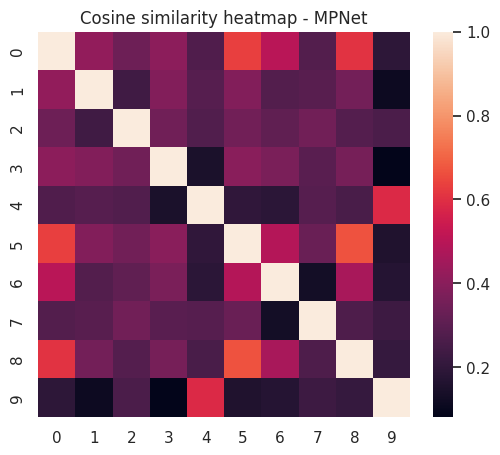

In [ ]:
for name, mat in sim_matrices.items():
    plt.figure(figsize=(6,5))
    sns.heatmap(mat, annot=False)
    plt.title(f'Cosine similarity heatmap - {name}')
    plt.show()

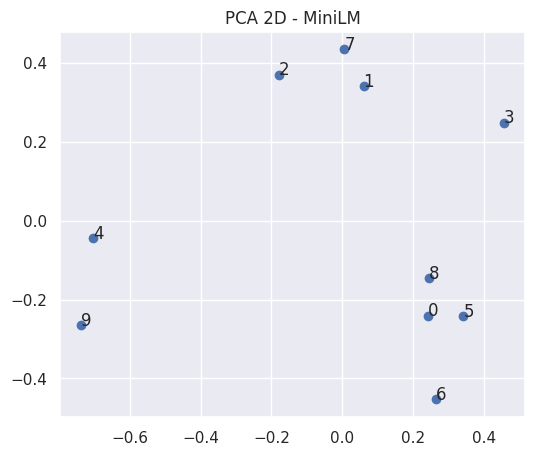

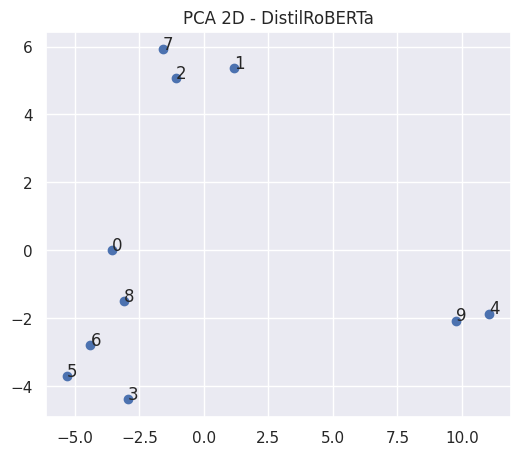

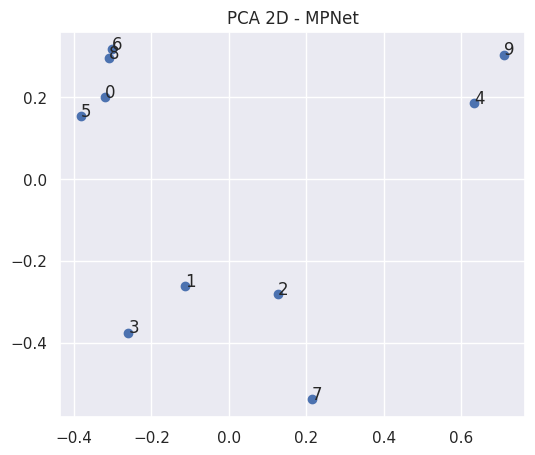

In [ ]:
for name, emb in summary_embeddings.items():
    pca = PCA(n_components=2)
    Xp = pca.fit_transform(emb)
    plt.figure(figsize=(6,5))
    plt.scatter(Xp[:,0], Xp[:,1])
    for i in range(len(snippets)):
        plt.annotate(str(i), (Xp[i,0], Xp[i,1]))
    plt.title(f'PCA 2D - {name}')
    plt.show()

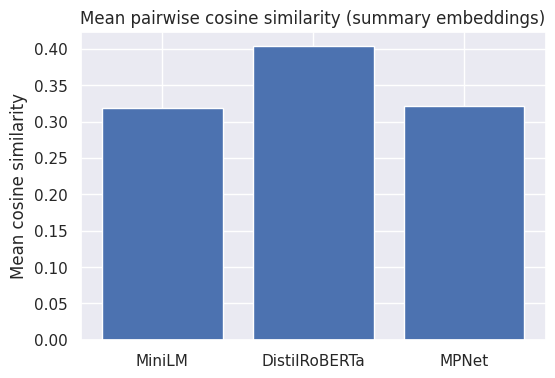

In [ ]:
names = list(mean_pairwise.keys())
vals = [mean_pairwise[n] for n in names]
plt.figure(figsize=(6,4))
plt.bar(names, vals)
plt.title('Mean pairwise cosine similarity (summary embeddings)')
plt.ylabel('Mean cosine similarity')
plt.show()

In [ ]:
out = {
    'snippets': snippets,
    'summaries': texts,
    'summary_embeddings': {k: v.tolist() for k,v in summary_embeddings.items()},
    'raw_embeddings': {k: v.tolist() for k,v in raw_embeddings.items()},
    'sim_matrices': {k: v.tolist() for k,v in sim_matrices.items()},
}
with open('milestone1_results.json','w') as f:
    json.dump(out,f)
print('Saved milestone1_results.json')

Saved milestone1_results.json


In [ ]:
from google.colab import drive
drive.mount('/content/drive')